In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

In [3]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [4]:
path = Path('/data/Datasets/EIPH_WSI/Patches/')

In [5]:
def get_float_labels(x: Path):
    return float(x.parent.stem)

In [6]:
tfms = get_transforms(do_flip=True, 
                      flip_vert=True, 
                      max_rotate=90,  
                      max_lighting=0., 
                      #max_zoom=2, 
                      #max_warp=0.2,
                      #p_affine=0.75,
                      #p_lighting=0.75,  
                      #xtra_tfms=xtra_tfms,
                     )

In [35]:
data = (ImageList.from_folder(path)
 .random_split_by_pct()
 .label_from_func(get_float_labels, label_cls=FloatList)
 .transform(tfms, size=32)
 .databunch(bs=64)) 
data.normalize()

ImageDataBunch;

Train: LabelList (62434 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: FloatList
2.0,2.0,2.0,2.0,2.0
Path: /data/Datasets/EIPH_WSI/Patches;

Valid: LabelList (15608 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: FloatList
1.0,0.0,2.0,0.0,1.0
Path: /data/Datasets/EIPH_WSI/Patches;

Test: None

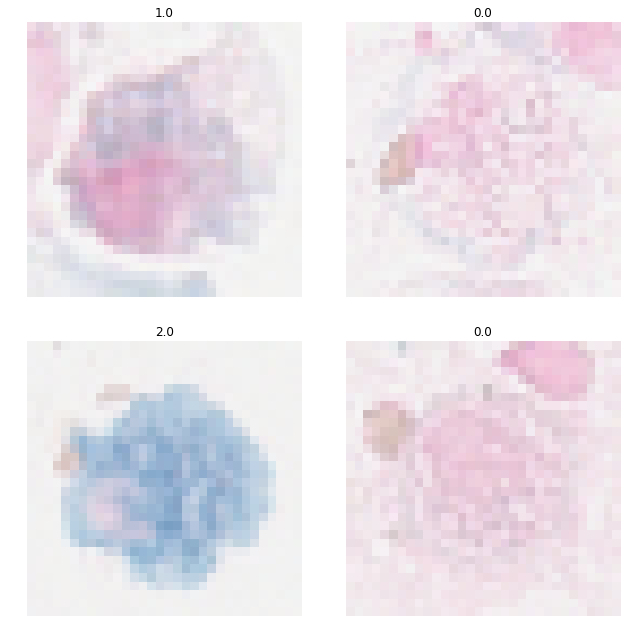

In [36]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

In [19]:
class L1LossFlat(nn.L1Loss):
    #Mean Absolute Error Loss
    def forward(self, input:Tensor, target:Tensor) -> Rank0Tensor:
        return super().forward(input.view(-1), target.view(-1))

In [55]:
def create_regression_head(nf:int, nc:int, y_range=[-0.5,4.5],
                           lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5, bn_final:bool=False):
    "Model head that takes `nf` features, runs through `lin_ftrs`, and about `nc` classes."
    lin_ftrs = [nf, 512, nc] if lin_ftrs is None else [nf] + lin_ftrs + [nc]
    ps = listify(ps)
    if len(ps)==1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    layers = [AdaptiveConcatPool2d(), Flatten()]
    for ni,no,p,actn in zip(lin_ftrs[:-1],lin_ftrs[1:],ps,actns):
        layers += bn_drop_lin(ni,no,True,p,actn)
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    if y_range is not None: layers.append(SigmoidRange(*y_range))
    return nn.Sequential(*layers)

In [26]:
def conv2d_relu(ni:int, nf:int, ks:int=3, stride:int=1,
                    padding:int=None, bn:bool=False, bias=True) -> nn.Sequential:
    "Create a `conv2d` layer with `nn.ReLU` activation and optional(`bn`) `nn.BatchNorm2d`"
    layers = [conv2d(ni, nf, ks=ks, stride=stride, padding=padding, bias=bias), nn.ReLU()]
    if bn: layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

def head_box_reg_subnet(n_classes, n_anchors, n_conv=4, chs=256, y_range=[-0.5,4.5]):
    layers = [conv2d_relu(chs, chs, bias=True) for _ in range(n_conv)]
    layers += [conv2d(chs, n_classes * n_anchors, bias=True)]
    layers.append(SigmoidRange(*y_range))
    
    return nn.Sequential(*layers)

In [27]:
head = head_box_reg_subnet(1, 1, 2, 512)

In [28]:
head

Sequential(
  (0): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): Conv2d(512, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): SigmoidRange()
)

In [61]:
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5)
  (8): Linear(in_features=512, out_features=1, bias=True)
  (9): SigmoidRange()
)

In [37]:
learn = create_cnn(data, models.resnet18, callback_fns=[ShowGraph], custom_head=head)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


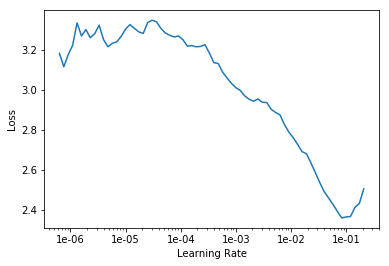

In [23]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,time
0,0.206758,0.264131,00:50
1,0.141532,0.117910,00:38
2,0.123073,0.109186,00:38
3,0.120578,0.106200,00:37
4,0.118668,0.104267,00:37


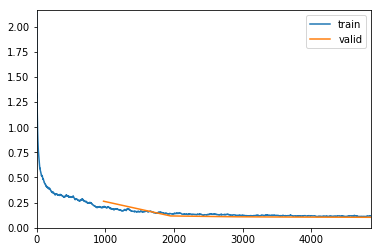

In [38]:
lr = 0.01
learn.fit_one_cycle(5, slice(lr))

In [40]:
learn.unfreeze()

epoch,train_loss,valid_loss,time
0,0.112721,0.105768,00:39
1,0.111000,0.104416,00:38
2,0.108184,0.100537,00:38
3,0.106495,0.100754,00:38
4,0.099392,0.098384,00:38
5,0.099382,0.097600,00:38
6,0.099902,0.096283,00:38
7,0.097907,0.095353,00:38
8,0.094825,0.094499,00:38
9,0.098232,0.094902,00:38


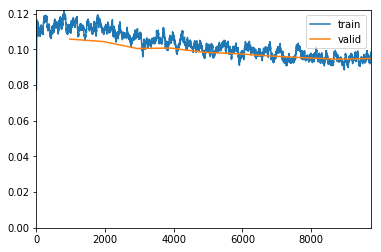

In [41]:
lr = 0.001
learn.fit_one_cycle(10, slice(1e-5, lr/5))

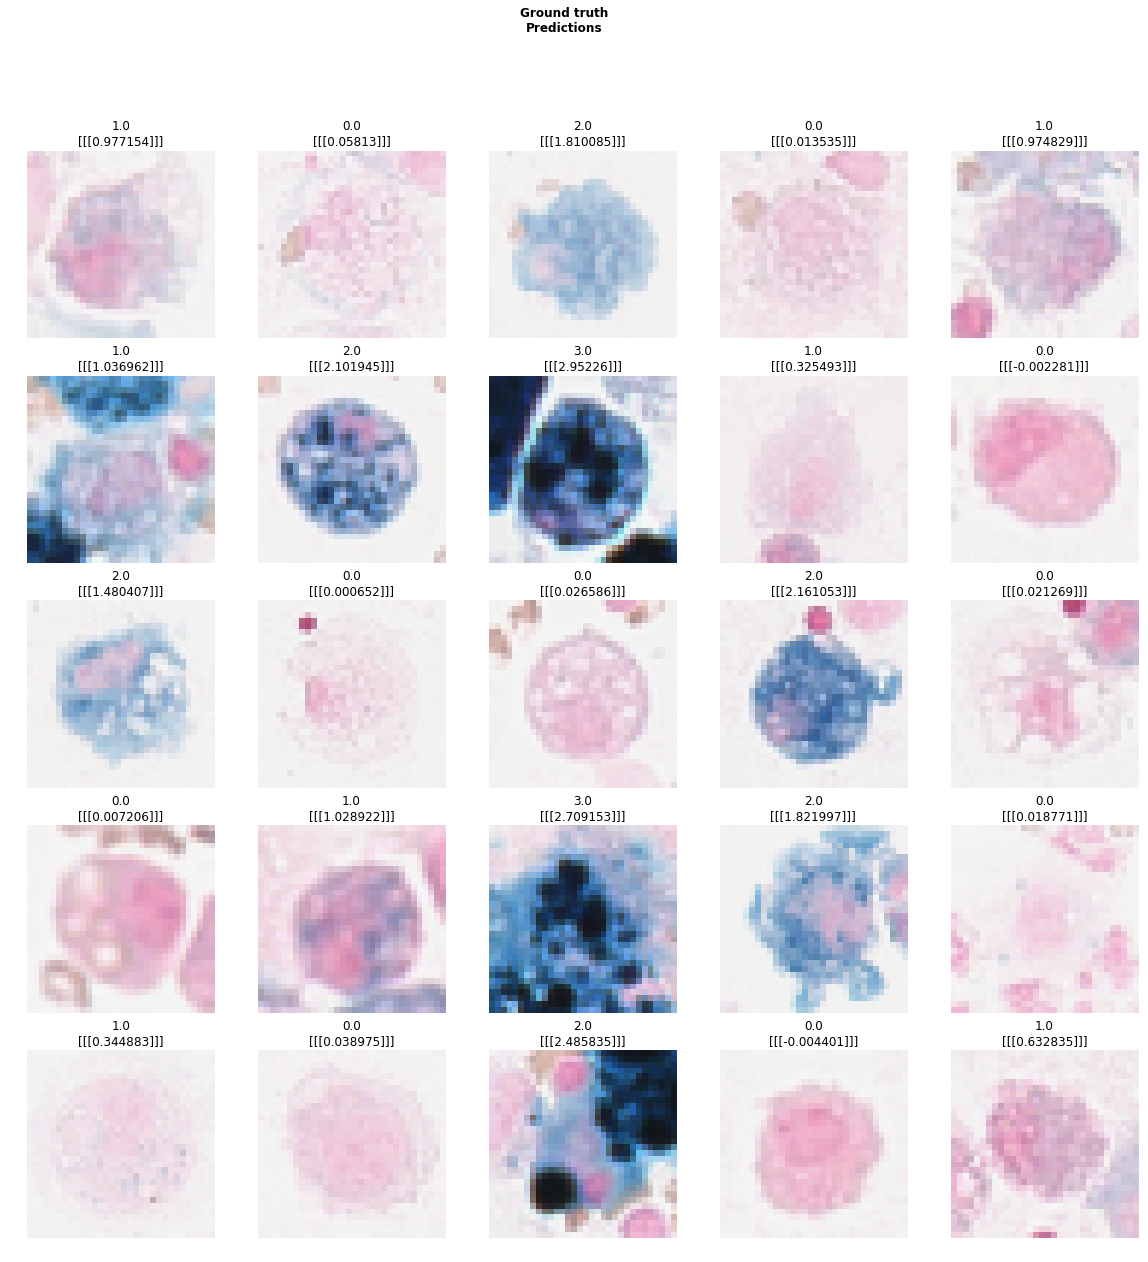

In [42]:
learn.show_results()

In [43]:
y_pred, y_true = learn.get_preds(ds_type=DatasetType.Valid)

In [44]:
y_pred = to_np(y_pred).flatten()
y_true = to_np(y_true).astype(np.uint)

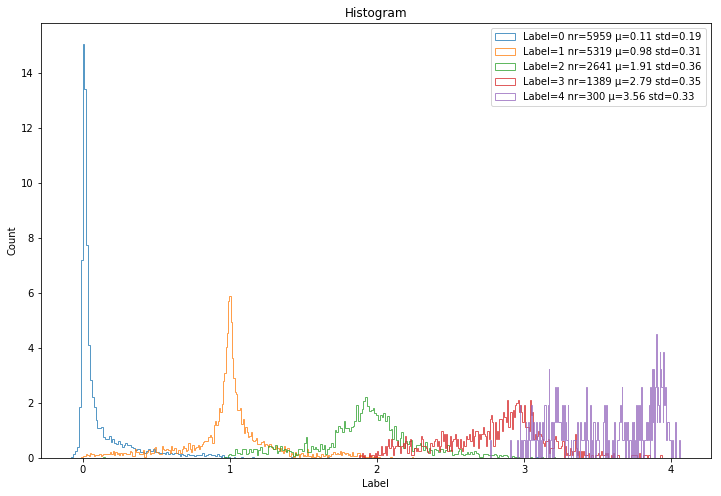

In [45]:
plt.figure(figsize=(12, 8))

for i in set(y_true): 
    y_pred_temp = y_pred[np.where(y_true == i)]
    mean = np.mean(y_pred_temp)
    std = np.std(y_pred_temp)
    n, bins, patches = plt.hist(y_pred_temp, 
                                250, 
                                normed=1, 
                                alpha=0.75, 
                                histtype='step', label="Label={} nr={} µ={:1.2f} std={:1.2f}".format(i, len(y_pred_temp),  mean, std),
                               #log =True
                               )


plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Histogram')


plt.legend(loc='best');
plt.show()